In [1]:
# Here we import everything we need for the project

%matplotlib inline
import os, time
import csv

# pytorch
import torch
from torch.nn import Module, Conv2d, MaxPool2d, Linear
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# Sklearn
from sklearn.model_selection import train_test_split # Helps with organizing data for training
from sklearn.metrics import confusion_matrix, classification_report # Helps present results as a confusion-matrix

## Loading Data

This project uses the [Hand Gesture Recognition Database](https://www.kaggle.com/gti-upm/leapgestrecog/version/1) (citation below) available on Kaggle. It contains 20000 images with different hands and hand gestures. There is a total of 10 hand gestures of 10 different people presented in the dataset. There are 5 female subjects and 5 male subjects.
The images were captured using the Leap Motion hand tracking device.

>Hand Gesture | Label used
>--- | ---
> Thumb down | 0
> Palm (Horizontal) | 1
> L | 2
> Fist (Horizontal) | 3
> Fist (Vertical) | 4
> Thumbs up | 5
> Index | 6
> OK | 7
> Palm (Vertical) | 8
> C | 9

Table 1 - Classification used for every hand gesture.


T. Mantecón, C.R. del Blanco, F. Jaureguizar, N. García, “Hand Gesture Recognition using Infrared Imagery Provided by Leap Motion Controller”, Int. Conf. on Advanced Concepts for Intelligent Vision Systems, ACIVS 2016, Lecce, Italy, pp. 47-57, 24-27 Oct. 2016. (doi: 10.1007/978-3-319-48680-2_5)  

Overview:
- Load images
- Some validation
- Preparing the images for training
- Use of train_test_split

In [2]:
# Unzip images, ignore this cell if files are already in the workspace
#!unzip leapGestRecog.zip

## Writing CSV - Kaggle Dataset
Since this dataset doesn't come with a nice csv, write one ourselves to make loading the data easier later

In [4]:
header = ["path_to_file", "class/GT"]
csv_path = "kaggle_images.csv"
# We need to get all the paths for the images to later load them
imagepaths = []
root = "./leapgestrecog"

for dirname, dirs, files in os.walk(root):
    for fname in files:
        path = os.path.join(dirname, fname)
        if path.endswith(".png"):
            imagepaths.append(path)

print(len(imagepaths)) # If > 0, then a PNG image was loaded
categories = [fpath.split("/")[4] for _, fpath in enumerate(imagepaths)]
gt = [category.split("_")[0] for _, category in enumerate(categories)]
with open(csv_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(header)
    for i, fpath in enumerate(imagepaths):
        writer.writerow([fpath, gt[i]])

20000


## Writing CSV - Kaggle Dataset
Since this dataset doesn't come with a nice csv, write one ourselves to make loading the data easier later
Note: directly setting filepaths to the pre-binarized images so we don't need to perform this operation ourselves

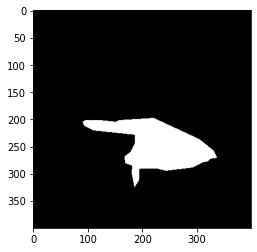

In [13]:
header = ["path_to_file", "GT"]
csv_path = "./data/asl/asl_images.csv"
imagepaths = []
fnames = []
# these are 400x400 BW images
root = "./data/asl/asl_data/binary_frames"

for dirname, dirs, files in os.walk(root):
    for fname in files:
        if fname.endswith(".png"):
            fnames.append(fname)
        path = os.path.join(dirname, fname)
        if path.endswith(".png"):
            imagepaths.append(path)

gt = [fname.split('_')[0] for fname in fnames]
with open(csv_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(header)
    for i, fpath in enumerate(imagepaths):
        writer.writerow([fpath, gt[i]])

## ASL Helpers
Mostly used to create a somewhat balanced train/test split, and to visualize counts of every class

In [3]:
def make_asl_count_df(y):
    counts = np.zeros(26)
    y = np.array(y)
    for i in range(26):
        counts[i] = np.sum(np.where(y == i, 1, 0))
    idx = [chr(i) for i in range(97, 123)]
    columns=["Count"]
    df = pd.DataFrame(counts, index=idx, columns=columns)
    return df

def y_as_np_arr(dataset):
    return np.array([sample['y'] for sample in dataset])


def make_asl_train_test_split(dataset, counts_df, split_ratio=0.75, train_csv="./data/asl/train_asl.csv", test_csv="./data/asl/test_asl.csv"):
    header = ["path_to_file", "GT"]
    train = []
    test = []
    np.random.seed(0)
    train_counts, test_counts = [int(np.ceil(split_ratio*counts_df.iloc[idx, 0])) for idx in range(counts_df.shape[0])], [int(np.floor((1-split_ratio)*counts_df.iloc[idx, 0])) for idx in range(counts_df.shape[0])]
    y = y_as_np_arr(dataset)
    for idx in range(counts_df.shape[0]):
        #curr_train_selections = []
        #curr_test_selections = []
        only_class_locs = np.where(y==idx)[0]
        train_idxes = np.random.choice(only_class_locs, size=train_counts[idx], replace=False)
        for data_idx in only_class_locs:
            sample = dataset[data_idx]
            if data_idx in train_idxes:
                #curr_train_selections.append(sample['fname'])
                train.append(sample['fname'])
            else:
                #curr_test_selections.append(sample['fname'])
                test.append(sample['fname'])
        #train.append(curr_train_selections)
        #test.append(curr_test_selections)
    train_lasts = [fname.split('/')[-1] for fname in train]
    train_gt = [fname.split('_')[0] for fname in train_lasts]
    test_lasts = [fname.split('/')[-1] for fname in test]
    test_gt = [fname.split('_')[0] for fname in test_lasts]
    with open(train_csv, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(header)
        for i, fpath in enumerate(train):
            writer.writerow([fpath, train_gt[i]])
    with open(test_csv, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(header)
        for i, fpath in enumerate(test):
            writer.writerow([fpath, test_gt[i]])
    return train, test

asl_dataset = AslGestureDataset(csv_file="./data/asl/asl_images.csv", transforms=[recolor, to_tensor])
y = y_as_np_arr(asl_dataset)
df = make_asl_count_df(y)
#train, test = make_asl_train_test_split(asl_dataset, df)
#print(test)

lasts = [fname.split('/')[-1] for fname in test]
gt = [fname.split('_')[0] for fname in lasts]
print(len(gt))
train_asl_dataset = AslGestureDataset(csv_file="./data/asl/train_asl.csv", transforms=[recolor, to_tensor])
print(len(train_asl_dataset))
#plt.imshow(np.squeeze(test[0][0]['image'].numpy()))

NameError: name 'AslGestureDataset' is not defined

## Dataloaders
To facilitate using pytorch to build our cnn, we write a custom DataLoader class. This allows for on-demand loading of images, which are used to train our cnn.

In [2]:
class KaggleHandDetectionDataset(Dataset):
    """Custom loader for the Kaggle Hand Detection Dataset"""
    
    def __init__(self, csv_file, transforms=None):
        """
        Args:
            csv_file (string): Path to the csv file with image filepaths and gt classes
            transforms (callable, optional): Optional transforms to be applied on a sample
        """
        self.images_frame = pd.read_csv(csv_file)
        #print(self.images_frame)
        self.transforms = transforms
        
    def __len__(self):
        return len(self.images_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = self.images_frame.iloc[idx, 0]
        img = cv2.imread(img_name)
        y = int(self.images_frame.iloc[idx, 1])-1
        sample = {'image' : img, 'y' : y, 'fname' : img_name}
        
        if len(self.transforms) > 0:
            for _, transform in enumerate(self.transforms):
                sample = transform(sample)
        return sample


In [3]:
class AslGestureDataset(Dataset):
    """Custom loader for the Kaggle Hand Detection Dataset"""
    
    def __init__(self, csv_file, transforms=None):
        """
        Args:
            csv_file (string): Path to the csv file with image filepaths and gt classes
            transforms (callable, optional): Optional transforms to be applied on a sample
        """
        self.images_frame = pd.read_csv(csv_file)
        self.transforms = transforms
        
    def __len__(self):
        return len(self.images_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = self.images_frame.iloc[idx, 0]
        #print(img_name)
        img = cv2.imread(img_name)
        y = (self.images_frame.iloc[idx, 1])
        # normalize to 0-26 for classes (missing j and z b/c dynamic)
        y = ord(y)- ord('a')
        sample = {'image' : img, 'y' : y, 'fname' : img_name}
        
        if len(self.transforms) > 0:
            for _, transform in enumerate(self.transforms):
                sample = transform(sample)
        return sample

In [4]:
class Rescale(object):
    """Used to rescale an image to a given size. Useful for the CNN
    
    Args:
        output_size (tuple or int): Desired output size after rescaling. If tuple, output is matched to output_size.
        If int smaller of width/height is matched to output_size, keeping aspect ratio the same.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        y = sample['y']
        image = sample['image']
        
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h // w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w // h
        else:
            new_h, new_w = self.output_size
        
        img = cv2.resize(image, (new_h, new_w))
        #print(f"after resize: {img.shape}")
        return {'image' : img, 'y' : y, 'fname' : sample['fname']}
    
class Recolor(object):
    """Used to recolor an image using cv2
    
    Args:
        flag (cv2.COLOR_): color to swap to
    """
    def __init__(self, color):
        self.color = color
    
    def __call__(self, sample):
        y = sample['y']
        image = sample['image']
        #print(f"before recolor: {image.shape}")
        
        # cvtColor to gray drops the damned channel dimension but we need it
        img_cvt = cv2.cvtColor(image, self.color)
        # fucking hack an extra dim to appease pytorch's bitchass
        img_cvt = np.expand_dims(img_cvt, axis=-1)
        #print(f"after exansion: {img_cvt.shape}")
        return {'image' : img_cvt, 'y' : y, 'fname' : sample['fname']}

class ToTensor(object):
    """Convert ndarrays to pytorch Tensors"""
    
    def __call__(self, sample):
        y = sample['y']
        image = sample['image']
        
        # swap color axis b/c 
        # numpy img: H x W x C
        # torch img: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image' : torch.from_numpy(image), 'y' : y, 'fname' : sample['fname']}

In [5]:
def prediction_to_class_str(pred):
    classes = {0 : "palm", 1 : "L", 2 : "fist", 3 : "fist_moved", 4 : "thumb", 5 : "index", 6 : "ok", 7 : "palm_moved", 8 : "c", 9 : "down"}
    return classes[pred]

def classify_arbitrary_image(model, img):
    img_type = type(img)
    print(img_type)
    if img_type == torch.Tensor:
        print("tensor")
        img = img.float()
        img = img.unsqueeze(1)
    elif img_type == np.ndarray:
        print("np array")
        img = np.expand_dims(img, 1)
    else:
        print("error: something other than a torch.Tensor or an np.ndarray was passed as img")
    prediction = model(img)
    prediction = prediction.data.numpy()
    y_hat = np.argmax(prediction, axis=1)
    return prediction_to_class_str(y_hat[0])

def classify_many_images(model, imgs):
    # for now, assuming imgs is a list of images that are either np.ndarrays or torch.Tensors
    # labels will be given back in order images were given
    predictions = []
    for img in imgs:
        predictions.append(classify_arbitrary_image(model, img))
    return predictions

In [6]:
class HandNNModel(Module):
    def __init__(self):
        super().__init__()
        
        # input shape = (32, 256, 256) - (batch_size, w, h) from dataloader
        self.conv1 = Conv2d(1, 32, kernel_size=5) # output shape: (252, 252, 32)
        self.pool1 = MaxPool2d(2) # output shape: (121, 121, 32)
        self.conv2 = Conv2d(32, 64, kernel_size=3) # output shape: (119, 119, 64)
        self.pool2 = MaxPool2d(2) # output shape: (59, 59, 64) - torch uses floor by default
        self.conv3 = Conv2d(64, 64, kernel_size=3) # output shape: (57, 57, 64)
        self.pool3 = MaxPool2d(2) # output shape: (28, 28, 64)
        self.fc1 = Linear(28*28*64, 128) # output shape: (28*28*64, 128)
        self.fc2 = Linear(128, 10)
        self.activation = torch.nn.ReLU()
        
    def forward(self, X):
        X = self.activation(self.conv1(X))
        X = self.pool1(X)
        X = self.activation(self.conv2(X))
        X = self.pool2(X)
        X = self.activation(self.conv3(X))
        X = self.pool3(X)
        X = torch.flatten(X, 1) # flatten with start_dim = 1
        X = self.fc1(X)
        X = self.fc2(X)
        output = F.softmax(X)
        return output

In [7]:
class AslNNModel(Module):
    # same structure as HandNNModel, need to change dimensions
    def __init__(self):
        super().__init__()
        
        # input shape = (64, 400, 400) - (batch_size, w, h) from dataloader
        self.conv1 = Conv2d(1, 32, kernel_size=5) # output shape: (496, 496, 32)
        self.pool1 = MaxPool2d(2) # output shape: (198, 198, 32)
        self.conv2 = Conv2d(32, 64, kernel_size=3) # output shape: (196, 196, 64)
        self.pool2 = MaxPool2d(2) # output shape: (98, 98, 64) - torch uses floor by default
        self.conv3 = Conv2d(64, 64, kernel_size=3) # output shape: (96, 96, 64)
        self.pool3 = MaxPool2d(2) # output shape: (48, 48, 64)
        self.fc1 = Linear(48*48*64, 128) # output shape: (48*48*64, 128)
        self.fc2 = Linear(128, 26) # 24 possible output classes, but it goes up to idx 26: CUDA screams otherwise, so here we are
        self.activation = torch.nn.ReLU()
        
    def forward(self, X):
        X = self.activation(self.conv1(X))
        X = self.pool1(X)
        X = self.activation(self.conv2(X))
        X = self.pool2(X)
        X = self.activation(self.conv3(X))
        X = self.pool3(X)
        X = torch.flatten(X, 1) # flatten with start_dim = 1
        X = self.fc1(X)
        X = self.fc2(X)
        output = F.softmax(X)
        return output

In [8]:
resize = Rescale((256,256))
recolor = Recolor(cv2.COLOR_BGR2GRAY)
to_tensor = ToTensor()
transforms = [resize, recolor, to_tensor]

hand_dataset = KaggleHandDetectionDataset(csv_file="kaggle_images.csv", transforms=transforms)

# for some reason, even with the binarization, there's 3 channels, but we only want one - so, use recolor
asl_dataset = AslGestureDataset(csv_file="./data/asl/asl_images.csv", transforms=[recolor, to_tensor])
train_asl_dataset = AslGestureDataset(csv_file="./data/asl/train_asl.csv", transforms=[recolor, to_tensor])
print(len(train_asl_dataset))
df = pd.read_csv("kaggle_images.csv")

sample = asl_dataset[0]
print()
print(sample['image'].shape)
print(sample['y'])
print(sample)
sample = hand_dataset[0]
print()
print(sample['image'].shape)
print(sample['y'])
print(sample)

720

torch.Size([1, 400, 400])
23
{'image': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8), 'y': 23, 'fname': './data/asl/asl_data/binary_frames/x_6-38.png'}

torch.Size([1, 256, 256])
0
{'image': tensor([[[ 6,  6,  7,  ...,  5,  5,  4],
         [ 7,  6,  5,  ...,  6,  4,  5],
         [ 5,  5,  4,  ...,  3,  4,  5],
         ...,
         [ 5,  5,  6,  ...,  3,  4,  4],
         [ 4,  4,  4,  ...,  6,  4,  5],
         [ 5,  5,  4,  ..., 34,  7, 13]]], dtype=torch.uint8), 'y': 0, 'fname': './leapgestrecog/leapGestRecog/02/01_palm/frame_02_01_0156.png'}


In [10]:
"""
sample = asl_dataset[0]
print()
print(sample['image'].shape)
print(sample['y'])
print(sample)
sample = hand_dataset[0]
img = sample['image']
#recolor = Recolor(cv2.COLOR_BGR2GRAY)
#as_gray = recolor(sample)
#scale = Rescale((256, 256))
#tns = ToTensor()
#as_tns = tns(sample)
#print(type(as_tns['image']))
#new_img = scale(sample)
print(sample['image'])
# complains b/c the gpu owns it, not the cpu since it's a tensor
cv2.imshow('original', sample['image'])
cv2.waitKey(2000)
#cv2.imshow('recolored', as_gray['image'])
#cv2.waitKey(2000)
#cv2.imshow('rescaled', new_img['image'])
#cv2.waitKey(3000)
cv2.destroyAllWindows()
"""

"\nsample = hand_dataset[0]\nimg = sample['image']\n#recolor = Recolor(cv2.COLOR_BGR2GRAY)\n#as_gray = recolor(sample)\n#scale = Rescale((256, 256))\n#tns = ToTensor()\n#as_tns = tns(sample)\n#print(type(as_tns['image']))\n#new_img = scale(sample)\nprint(sample['image'])\n# complains b/c the gpu owns it, not the cpu since it's a tensor\ncv2.imshow('original', sample['image'])\ncv2.waitKey(2000)\n#cv2.imshow('recolored', as_gray['image'])\n#cv2.waitKey(2000)\n#cv2.imshow('rescaled', new_img['image'])\n#cv2.waitKey(3000)\ncv2.destroyAllWindows()\n"

In [37]:
dataloader = DataLoader(asl_dataset, batch_size=4)
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size())
    if i_batch == 3:
        break

./data/asl/asl_data/binary_frames/x_6-38.png
./data/asl/asl_data/binary_frames/p_7-57.png
./data/asl/asl_data/binary_frames/g_2-38.png
./data/asl/asl_data/binary_frames/q_8-38.png
0 torch.Size([4, 1, 400, 400])
./data/asl/asl_data/binary_frames/p_4-57.png
./data/asl/asl_data/binary_frames/h_4-38.png
./data/asl/asl_data/binary_frames/s_1-19.png
./data/asl/asl_data/binary_frames/l_3-76.png
1 torch.Size([4, 1, 400, 400])
./data/asl/asl_data/binary_frames/w_4-38.png
./data/asl/asl_data/binary_frames/a_4-19.png
./data/asl/asl_data/binary_frames/c_6-57.png
./data/asl/asl_data/binary_frames/d_1-95.png
2 torch.Size([4, 1, 400, 400])
./data/asl/asl_data/binary_frames/l_5-95.png
./data/asl/asl_data/binary_frames/n_7-38.png
./data/asl/asl_data/binary_frames/h_8-76.png
./data/asl/asl_data/binary_frames/s_1-57.png
3 torch.Size([4, 1, 400, 400])


## Train the model using the Custom Dataloader
Below, we will actually train our CNN model

In [13]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
if use_cuda:
    params = {'batch_size' : 48, 'shuffle': True, 'num_workers' : 8, 'pin_memory' : True}
else:
    params = {'batch_size' : 48, 'shuffle': True, 'num_workers' : 8}
    

max_epochs = 700 
data_loader = DataLoader(train_asl_dataset, **params)
model = AslNNModel()
# move to GPU
if use_cuda:
    model.cuda()

# batch_size, num_channels, w, h
#random_data = torch.rand((1, 1, 256, 256))

#result = model(random_data)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#imgs, labels = (next(iter(data_loader)))
start = time.time()
for epoch in range(max_epochs):
    print(f"start epoch {epoch}")
    running_loss = 0.0
    epoch_start = time.time()
    for i, data in enumerate(data_loader):
        imgs, labels = data['image'], data['y']
        # move to GPU
        imgs, labels = imgs.cuda(), labels.cuda()
        imgs = imgs.float()
        optimizer.zero_grad()
        
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 10 == 0:
            print(f"epoch {epoch}: running loss = {running_loss}")
    epoch_end = time.time()
    print(f"epoch {epoch} runtime = {epoch_end - epoch_start}")
end = time.time()
print(f"Total training time = {end - start}")

# make sure to save the model so we don't need to train again
save = True
if save:
    save_path = "./data/asl/asl_train_no_tl_same_model.pkl"
    torch.save(model.state_dict(), save_path)

start epoch 0


<ipython-input-7-1a7815147b0d>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(X)


epoch 0: running loss = 3.23928165435791
epoch 0: running loss = 36.01439380645752
epoch 0 runtime = 3.74021053314209
start epoch 1
epoch 1: running loss = 3.238759994506836
epoch 1: running loss = 35.957186698913574
epoch 1 runtime = 3.7243735790252686
start epoch 2
epoch 2: running loss = 3.1965620517730713
epoch 2: running loss = 35.86404800415039
epoch 2 runtime = 3.7241523265838623
start epoch 3
epoch 3: running loss = 3.2804267406463623
epoch 3: running loss = 36.104058027267456
epoch 3 runtime = 3.690035820007324
start epoch 4
epoch 4: running loss = 3.2594709396362305
epoch 4: running loss = 36.10472846031189
epoch 4 runtime = 3.726332426071167
start epoch 5
epoch 5: running loss = 3.238759994506836
epoch 5: running loss = 35.895745277404785
epoch 5 runtime = 3.711392641067505
start epoch 6
epoch 6: running loss = 3.2801475524902344
epoch 6: running loss = 35.917240619659424
epoch 6 runtime = 3.7042717933654785
start epoch 7
epoch 7: running loss = 3.2386934757232666
epoch 7: r

In [12]:
#print(model.named_parameters)

params = model.parameters()

In [12]:
loaded_model = AslNNModel()
loaded_model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

## Saving Trained Model

In [13]:
#save_path = "./trained_test_cnn.pkl"
#torch.save(model.state_dict(), save_path)

## Loading the model
Load the model from disk later for evaluation

In [14]:
loaded_model = HandNNModel()
loaded_model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

## Confusion Matrix and Classification Report (from sklearn)


In [17]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
def make_stats(y, y_hat, num_classes=10):
    cm = confusion_matrix(y, y_hat)
    cm_df = pd.DataFrame(cm, columns=[str(i) for i in range(num_classes)])
    report = classification_report(y, y_hat)
    return cm_df, report

In [14]:
total_samples = 0
total_misclass = 0
test_data_loader = DataLoader(test_asl_dataset, **params)
all_y = np.array([], dtype=np.uint8)
all_y_hat = np.array([], dtype=np.uint8)
for i, sample in enumerate(data_loader):
    y = sample['y']
    y = y.data.numpy()
    images = (sample['image'])
    images = images.float()
    images = (sample['image'])
    images = images.float()
    model = model.cpu()
    predictions = model(images)
    predictions = predictions.cpu()
    predictions = predictions.data.numpy()
    y_hat = np.argmax(predictions, axis=1)
    misclass = np.sum(np.where(y != y_hat, 1, 0))
    total_samples += y.shape[0]
    total_misclass += misclass
    all_y = np.append(all_y, y)
    all_y_hat = np.append(all_y_hat, y_hat)
    #print(f"all_y = {all_y}")
    #print(f"all_y_hat = {all_y_hat}")
    print(f"Number of Misclassifications = {misclass}")
    print(f"Sample acc = {(y.shape[0]-misclass)/y.shape[0]*100}")
overall_acc = (total_samples - total_misclass)/total_samples
print(f"Overall Accuracy = {overall_acc}")

<ipython-input-7-1a7815147b0d>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(X)


all_y = [ 3 16 20 24 20  1 10  0 13  5  7 18 16  5 11  7  0  1  5  3  7 16 11  1
 15  6  7  2 13  4 23 14  1 10 20  3 18  4 15  3 17  5 24 20  6 23 12 16]
all_y_hat = [ 3 16 20 24 20  3 10  0 13  5  7 18 16  5 11  7  0  1  5  3  7 16  3  1
 15  6  7  2 13  4 23 14  1 10 20  3 18  4 15  3 17  5 24 20  7 23 12 16]
Number of Misclassifications = 3
Sample acc = 93.75
all_y = [ 3 16 20 24 20  1 10  0 13  5  7 18 16  5 11  7  0  1  5  3  7 16 11  1
 15  6  7  2 13  4 23 14  1 10 20  3 18  4 15  3 17  5 24 20  6 23 12 16
 22  5  8 14  1 11 12  8 16 14 18  8 14 12  7 22  8 22 11  2  6  5 14 18
 18 14  2 17 11 14  7 20 12 23 23 15 14  8  0  1  7 13  3  5  3 19 21 23]
all_y_hat = [ 3 16 20 24 20  3 10  0 13  5  7 18 16  5 11  7  0  1  5  3  7 16  3  1
 15  6  7  2 13  4 23 14  1 10 20  3 18  4 15  3 17  5 24 20  7 23 12 16
 17 12  8 14  5 11 12  8 16 14 18  8 14 12  7 10  8 20 17  2  6  5 14 18
 18 14  2 20 11 14  7 20 12 23 23 15 14  8  0  3  7 13  3  5  3  5 21 23]
Number of Misclassifications

In [21]:
cm_df, report = make_stats(all_y, all_y_hat, num_classes=24)
#print(cm_df.to_markdown())
print(cm_df)#.to_markdown())
print(report)

     0   1   2   3   4   5   6   7   8   9  ...  14  15  16  17  18  19  20  \
0   28   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
1    0  18   0   4   0   2   1   0   0   0  ...   0   0   0   0   1   1   1   
2    0   0  30   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
3    0   0   0  30   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
4    1   0   0   1  25   0   0   0   0   0  ...   0   0   0   1   0   0   0   
5    0   0   0   0   1  26   0   0   0   0  ...   0   0   0   1   1   0   0   
6    0   0   0   0   0   0  26   3   0   0  ...   1   0   0   0   0   0   0   
7    0   0   0   0   0   0   0  30   0   0  ...   0   0   0   0   0   0   0   
8    0   0   0   0   0   0   0   0  28   0  ...   0   0   0   0   1   0   0   
9    0   0   0   0   0   0   0   0   0  25  ...   0   0   0   0   0   2   2   
10   0   0   0   2   0   0   0   0   0   0  ...   0   0   1   0   0   1   0   
11   0   0   0   0   0   0   0   0   0   0  ...   0 

In [25]:
test_asl_dataset = AslGestureDataset(csv_file="./data/asl/test_asl.csv", transforms=[recolor, to_tensor])
test_data_loader = DataLoader(test_asl_dataset, **params)
all_y = np.array([], dtype=np.uint8)
all_y_hat = np.array([], dtype=np.uint8)
for i, sample in enumerate(test_data_loader):
    y = sample['y']
    y = y.data.numpy()
    images = (sample['image'])
    images = images.float()
    images = (sample['image'])
    images = images.float()
    model = model.cpu()
    predictions = model(images)
    predictions = predictions.cpu()
    predictions = predictions.data.numpy()
    y_hat = np.argmax(predictions, axis=1)
    misclass = np.sum(np.where(y != y_hat, 1, 0))
    total_samples += y.shape[0]
    total_misclass += misclass
    all_y = np.append(all_y, y)
    all_y_hat = np.append(all_y_hat, y_hat)
    #print(f"all_y = {all_y}")
    #print(f"all_y_hat = {all_y_hat}")
    print(f"Number of Misclassifications = {misclass}")
    print(f"Sample acc = {(y.shape[0]-misclass)/y.shape[0]*100}")
overall_acc = (total_samples - total_misclass)/total_samples
print(f"Overall Accuracy = {overall_acc}")

<ipython-input-7-1a7815147b0d>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(X)


Number of Misclassifications = 26
Sample acc = 45.83333333333333
Number of Misclassifications = 20
Sample acc = 58.333333333333336
Number of Misclassifications = 15
Sample acc = 68.75
Number of Misclassifications = 19
Sample acc = 60.416666666666664
Number of Misclassifications = 24
Sample acc = 50.0
Overall Accuracy = 0.8428571428571429


In [26]:
cm_df, report = make_stats(all_y, all_y_hat, num_classes=24)
#print(cm_df.to_markdown())
print(cm_df)#.to_markdown())
print(report)

    0  1  2  3  4  5  6  7  8  9  ...  14  15  16  17  18  19  20  21  22  23
0   3  0  0  0  1  0  0  0  0  0  ...   0   0   0   0   1   1   0   0   0   2
1   0  8  0  1  0  0  0  0  0  0  ...   0   0   0   0   0   1   0   0   0   0
2   1  0  6  0  0  0  0  0  0  0  ...   0   0   0   0   1   0   0   0   0   0
3   0  0  0  6  0  0  0  0  0  0  ...   0   0   0   2   0   1   0   0   0   0
4   1  0  0  2  3  0  0  0  0  0  ...   0   0   0   1   0   0   0   0   0   0
5   0  3  0  0  0  5  0  0  0  0  ...   0   0   0   1   0   1   0   0   0   0
6   0  0  0  0  0  0  8  1  0  0  ...   1   0   0   0   0   0   0   0   0   0
7   0  0  0  0  0  0  1  8  0  0  ...   0   0   0   0   0   1   0   0   0   0
8   0  0  0  0  0  0  0  0  3  0  ...   0   0   1   1   0   0   0   0   0   1
9   0  0  0  0  0  0  0  0  0  7  ...   0   0   0   0   0   0   2   0   0   1
10  0  0  0  1  0  0  0  0  0  1  ...   0   0   0   0   0   0   0   0   0   0
11  0  0  0  2  0  0  0  0  0  1  ...   0   0   0   0   0   0   

/home/sean/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
